<a href="https://colab.research.google.com/github/nhatanh81096/cs480student/blob/main/Anh_Vo_CS480_Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

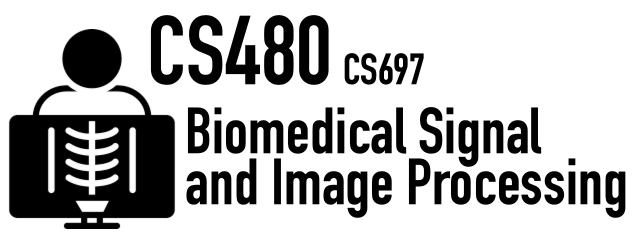
#Assignment 6

In [ ]:
# In this assignment, we will train a U-Net classifer to detect mitochondria
# in electron microscopy images!

In [ ]:
### IMPORTANT ###
#
# Activate GPU support: Runtime -> Change Runtime Type
# Hardware Accelerator: GPU
#
### IMPORTANT ###

In [ ]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# load the unet tensorflow code
!pip install git+https://github.com/jakeret/unet.git

  Cloning https://github.com/jakeret/unet.git to /tmp/pip-req-build-t5m5fdcu
  Running command git clone -q https://github.com/jakeret/unet.git /tmp/pip-req-build-t5m5fdcu
  Created wheel for unet: filename=unet-0.0.post0.dev81+gf557a51-py2.py3-none-any.whl size=25658 sha256=513d08fee81b3b61f69fa2b257931fab40e015759991485054d956d0f70bdf2f
  Stored in directory: /tmp/pip-ephem-wheel-cache-mz6ld_pg/wheels/f5/38/c8/8f0a157cfd7616cc1a24811a52b9a669c0ee8fccc9f99d3cbc
Successfully built unet


In [ ]:
# .. and use it!
# Note: There are a ton of U-Net implementations but this one is easier to use!
import unet

**Task 1**: Study the unet circle example and learn about mitochondria! [15 Points]

In [ ]:
# The unet package allows to train a U-Net classifier with little code.
# As discussed in class, the U-Net can be used to label/segment/annotate images.

In [ ]:
# TODO: Please study the Circles example 
# https://github.com/jakeret/unet/blob/master/notebooks/circles.ipynb

In [ ]:
# TODO: ... and look how the (artificial) dataset is generated
# https://github.com/jakeret/unet/blob/master/src/unet/datasets/circles.py

In [ ]:
# 1) Question
# TODO: Please describe what the U-Net is trained to do.
#
# TODO: YOUR ANSWER

U-Net is trained to do the segmentation im images. 

In the above example, U-Net is trained to detect the circles (segment the circles) in a noisy image

In [ ]:
# 2) Question
# TODO: In circles.py, what does the following mean:
#     channels = 1
#     classes = 2
#
# TODO: YOUR ANSWER

- Channels = 1 means there is only 1 channel in the input image

- Classes = 2 means there are 2 output classes (circle and no circle)

In [ ]:
# 3) Question
# TODO: What are mitochondria and what is their appearance in
# electron microscopy data?
# Hint: You can validate your answer in Task 4!
#
# TODO: YOUR ANSWER

- Mitochondria are organelles found in large numbers in most cells, in which the biochemical processes of respiration and energy production occur. It has a double membrane, the inner layer being folded inward to form layers (cristae). In addition to producing energy, mitochondria store calcium for cell signaling activities, generate heat, and mediate cell growth and death.

- Mitochondria are typically round to oval in shape 

**Task 2**: Setup a datagenerator for mitochondria images! [45 Points]

In [ ]:
# TODO: 
# Download https://cs480.org/data/mito.npz to your computer.
# Then, please upload mito.npz using the file panel on the left.

In [ ]:
!curl -O https://cs480.org/data/mito.npz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35.8M  100 35.8M    0     0  48.3M      0 --:--:-- --:--:-- --:--:-- 48.2M


In [ ]:
# The code below is similar to the circles.py file from Task 1.
# We follow Tensorflow conventions to design a tf.data.Dataset for training
# the U-Net.
#
# TODO: Please add four different data augmentation methods in the code block
# below. (image normalization to 0..1, horizontal data flip, vertical data flip,
# rotation by 90 degrees)
#
# Hint: https://github.com/jakeret/unet/blob/master/src/unet/datasets/oxford_iiit_pet.py#L25

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_datasets.core import DatasetInfo
from typing import Tuple, List

IMAGE_SIZE = (256, 256)
channels = 1
classes = 2

def load_data(count:int, splits:Tuple[float]=(0.7, 0.2, 0.1), **kwargs) -> List[tf.data.Dataset]:
    return [tf.data.Dataset.from_tensor_slices(_build_samples(int(split * count), **kwargs))
            for split in splits]


def _build_samples(sample_count:int, **kwargs) -> Tuple[np.array, np.array]:

    # here we load the mitochondria data
    loaded = np.load('mito.npz')
    loadedimages = loaded['arr_0'][0].copy()
    loadedmasks = loaded['arr_0'][1].copy()

    # now let's go to numpyland
    images = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
    labels = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 2))
    for i in range(sample_count):
        image, mask = loadedimages[i], loadedmasks[i]

        image = image.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1)).astype(np.float)
        mask = mask.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1))

        #
        # TODO: Normalize the image to 0..1
        #
        # TODO: YOUR CODE

        image = tf.cast(image, tf.float32) / 255.0
        mask -= 1

        #
        # TODO: Use Tensorflow to flip the image horizontally
        #
        if tf.random.uniform(()) > 0.5:
            #
            # TODO: YOUR CODE
            #
            image = tf.image.flip_left_right(image)
            mask = tf.image.flip_left_right(mask)

        #
        # TODO: Use Tensorflow to flip the image vertically
        #
        if tf.random.uniform(()) > 0.5:
            #
            # TODO: YOUR CODE
            #
            image = tf.image.flip_up_down(image)
            mask = tf.image.flip_up_down(mask)

        #
        # TODO: Use Tensorflow to rotate the image 90 degrees
        #
        if tf.random.uniform(()) > 0.5:
            #
            # TODO: YOUR CODE
            #
            image = tf.image.rot90(image)
            mask = tf.image.rot90(mask)


        # augmentation done, let's store the image
        images[i] = image

        # here we split the mask to background and foreground
        fg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        fg[mask == 255] = 1
        bg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        bg[mask == 0] = 1
        
        labels[i, :, :, 0] = bg[:,:,0]
        labels[i, :, :, 1] = fg[:,:,0]

    return images, labels

**Task 3**: Let's train the U-Net! [25 Points]

In [ ]:
#
# We can now create our training, validation, and testing data by calling
# our methods from Task 2.
#
train, val, test = load_data( 660, splits=(0.7, 0.2, 0.1) )

In [ ]:
# 1) Question
# TODO: We have in total 660 images + 660 masks. Based on the code above,
# how many images are used for training alone?
#
# TODO: YOUR ANSWER

70% of the images are used for training -> 0.7 * 660 = 462 images

20% of the images are used for validating -> 02 * 660 = 132 images

10% of the images are used for testing -> 0.1 * 660 = 66 images

In [ ]:
#
# Let's setup the U-Net!
#
LEARNING_RATE = 1e-3

unet_model = unet.build_model(channels=channels,
                              num_classes=classes,
                              layer_depth=5,
                              filters_root=64,
                              padding="same")

unet.finalize_model(unet_model, learning_rate=LEARNING_RATE)

In [ ]:
#
# And, let's setup the trainer...
#
trainer = unet.Trainer(checkpoint_callback=False,
                       learning_rate_scheduler=unet.SchedulerType.WARMUP_LINEAR_DECAY,
                       warmup_proportion=0.1,
                       learning_rate=LEARNING_RATE)

In [ ]:
#
# ...and train the U-Net for 50 epochs with a batch_size of 10!
#
# TODO: Please complete the code below.
# Hint: Don't forget to use training and validation data.
# Hint 2: This will take roughly 30 minutes!
#
trainer.fit(unet_model,
            train,
            val,
            epochs=50,
            batch_size=10)

Epoch 1/50
47/47 [==============================] - 31s 560ms/step - loss: 0.5980 - categorical_crossentropy: 0.5980 - categorical_accuracy: 0.4272 - mean_iou: 0.2527 - dice_coefficient: 0.5075 - auc: 0.5835 - val_loss: 0.4373 - val_categorical_crossentropy: 0.4373 - val_categorical_accuracy: 0.9434 - val_mean_iou: 0.3030 - val_dice_coefficient: 0.6101 - val_auc: 0.9932
Epoch 2/50
47/47 [==============================] - 20s 436ms/step - loss: 0.1121 - categorical_crossentropy: 0.1121 - categorical_accuracy: 0.9206 - mean_iou: 0.4161 - dice_coefficient: 0.8548 - auc: 0.9741 - val_loss: 0.3166 - val_categorical_crossentropy: 0.3166 - val_categorical_accuracy: 0.9434 - val_mean_iou: 0.3432 - val_dice_coefficient: 0.6939 - val_auc: 0.9934
Epoch 3/50
47/47 [==============================] - 20s 437ms/step - loss: 0.1189 - categorical_crossentropy: 0.1189 - categorical_accuracy: 0.9210 - mean_iou: 0.4122 - dice_coefficient: 0.8479 - auc: 0.9725 - val_loss: 0.0952 - val_categorical_crossentr

**Task 4**: Let's predict mitochondria in the testing data! [15 Points]

In [ ]:
# 
# After training, let's try the U-Net on our testing data.
#
# The code below displays the first 10 input images, the original masks by experts, 
# and the predicted masks from the U-Net.

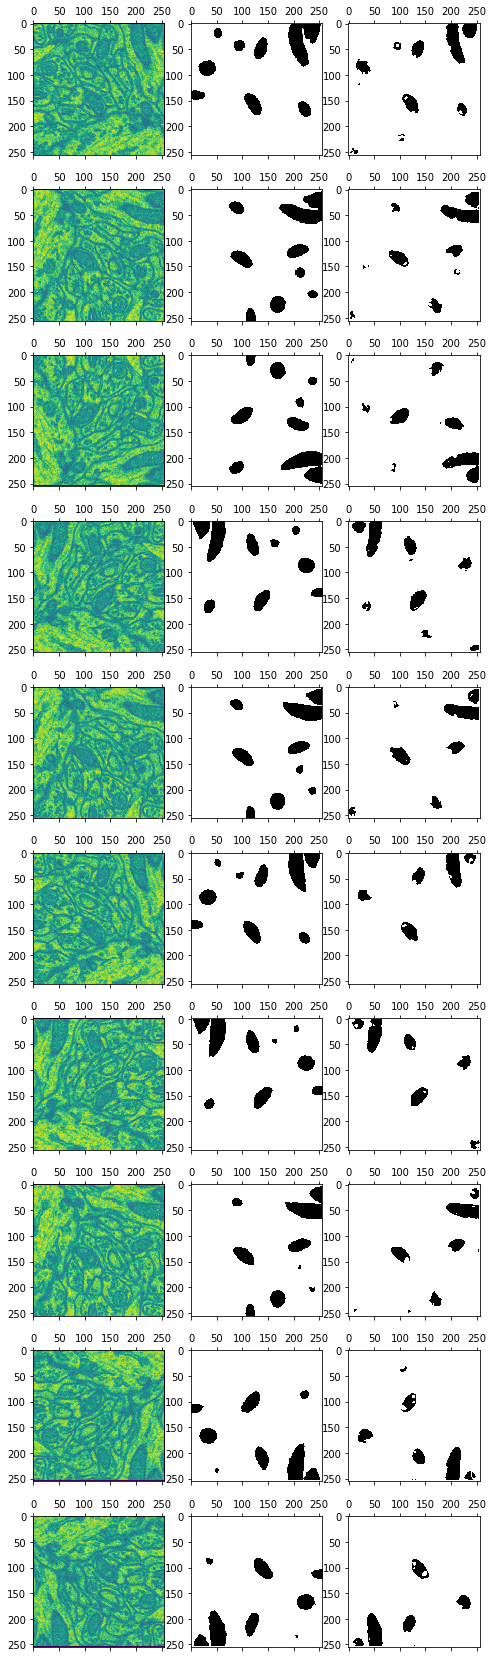

In [ ]:
rows = 10
fig, axs = plt.subplots(rows, 3, figsize=(8, 30))
for ax, (image, label) in zip(axs, test.take(rows).batch(1)):
  
  prediction = unet_model.predict(image)
  ax[0].matshow(image[0, :, :, 0])
  ax[1].matshow(label[0, :, :, 1], cmap="gray")
  ax[2].matshow(prediction[0].argmax(axis=-1), cmap="gray")

In [ ]:
# 1) Question
# TODO: Why do we use the prediction[0].argmax(axis=-1) command
# to display the prediction?
# 
# TODO: YOUR ANSWER

The output of U-Net is the probabilities that a pixel belong to each class. So we will need to use the argmax to assign the higher probability class to the pixels.

In [ ]:
# 2) Question
# TODO: Is the quality of the segmentation good and how could we improve it?
# Hint: Think along the lines of some traditional image processing rather than
# increasing the training data size.
#
# TODO: YOUR ANSWER

The segmentation is pretty good but it's not perfect. 

One way to improve the result of segmentation is that after the prediction, we can use the morphological opening and closing to fill the holes in the segmentation result. 

Another way to improve it is that we can use other augmentation techniques rather than just the above 4. We can also rotate the image in different degrees, scale the image, crop the image, etc.

**Bonus**: Compare against the state-of-the-art literature! [33 Points]

In [ ]:
#
# The following paper also uses a 2D U-Net to detect mitochondria:
# 
# https://danielhaehn.com/papers/?casser2020fast
#

In [ ]:
# 1) Question
#
# TODO: How many learnable parameters does your trained unet_model have?
# Hint: You can use TF's Model Summary function to answer this.
#

In [ ]:
unet_model.summary()

Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv_block (ConvBlock)          (None, None, None, 6 37568       inputs[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 6 0           conv_block[0][0]                 
__________________________________________________________________________________________________
conv_block_1 (ConvBlock)        (None, None, None, 1 221440      max_pooling2d[0][0]              
_______________________________________________________________________________________________

There are a total of 31,030,658 parameters in the UNet model

In [ ]:
# 2) Question
#
# TODO: How many parameters do Casser et al. use?
#

Casser et al. use only 1,958,533 parameters in their model

In [ ]:
# 3) Question
#
# TODO: How did Casser et al. reduce the parameters?
#

According to the paper, they reduce the number of convolutional filters throughout the network. 

They then replace transpose convolutions in the decoder with light-weight bilinear upsampling layers that require no parameters. 

For the encoder, they reach a parameter reduction of 94%, from 19,505,856 to 1,178,480. 

For the decoder, they reach a 93.6% reduction (from 12,188,545 to 780,053). 

In [ ]:
# 4) Question
#
# TODO: Why did Casser et al. reduce the parameters?
#

Reducing the number of parameters helps them to achieve a faster time (even the fastest one compared to previous works) when inferencing the model. This allows us to use the model for real-time detection of mitochondria.

In [ ]:
#
# You made it!!
#
#                 _ ___                /^^\ /^\  /^^\_
#     _          _@)@) \            ,,/ '` ~ `'~~ ', `\.
#   _/o\_ _ _ _/~`.`...'~\        ./~~..,'`','',.,' '  ~:
#  / `,'.~,~.~  .   , . , ~|,   ,/ .,' , ,. .. ,,.   `,  ~\_
# ( ' _' _ '_` _  '  .    , `\_/ .' ..' '  `  `   `..  `,   \_
#  ~V~ V~ V~ V~ ~\ `   ' .  '    , ' .,.,''`.,.''`.,.``. ',   \_
#   _/\ /\ /\ /\_/, . ' ,   `_/~\_ .' .,. ,, , _/~\_ `. `. '.,  \_
#  < ~ ~ '~`'~'`, .,  .   `_: ::: \_ '      `_/ ::: \_ `.,' . ',  \_
#   \ ' `_  '`_    _    ',/ _::_::_ \ _    _/ _::_::_ \   `.,'.,`., \-,-,-,_,_,
#    `'~~ `'~~ `'~~ `'~~  \(_)(_)(_)/  `~~' \(_)(_)(_)/ ~'`\_.._,._,'_;_;_;_;_;
#